# Code for CUQIpy paper 2, section 4. CUQIpy-FEniCS example: Electrical Impedance Tomography (EIT)

This notebook demonstrates how to run the code associated with the Electrical Impedance Tomography (EIT) problem shown in the paper. The details of setting up the problem in `CUQIpy` is in the script `EIT.py`, which you can run from this notebook, or externally. The notebook then uses the results generated by `EIT.py` to produce the figures shown in the paper. The results are saved in `stat` folder and the figures are saved in `plots` folder.

#### About `EIT.py`
The EIT problem setup in `EIT.py` uses the plug-in `CUQIpy-FEniCS` to solve the forward problem and interface with `CUQIpy` Bayesian modeling and sampling tools. We are after inferring the conductivity field in a 2D domain from boundary current measurements. `EIT.py` creates the PDE forward model, prior, likelihood, and posterior. It samples the posterior using `CUQIpy` and visualizes the results. We parametrize the prior using a combination of KL expansion and level-set parameterization.

First, we import required libraries and classes:

In [1]:
import numpy as np
import dolfin as dl
import matplotlib.pyplot as plt
import os
import cuqi
import cuqipy_fenics
from cuqi.distribution import Gaussian
from cuqi.samples import Samples
from EIT import extract_boundary_dofs_indices, create_domain_geometry
from figures_util import plot_figure6, plot_figure7, plot_figure8, plot_figure9

Print `CUQIpy`, `CUQIpy-FEniCS`, and `dolfin` versions (we show `pip freeze` output at the end of this notebook for a complete list of versions).

In [2]:
print(cuqi.__version__)
print(cuqipy_fenics.__version__)
print(dl.__version__)

1.0.0
0.7.0
2019.1.0


For each noise level, we run the python script `EIT.py` that solves the Bayesian EIT problem and save the results in folder `stat`. This could take about 6 to 7 hours to run for each noise level. You can set the number of samples to a smaller value to get results quicker for a shorter MCMC chain. Note that you will also need to set the burn-in and the thinning accordingly. The command line to run the script is:

`python EIT.py <noise_percent> <num_samples> <num_burnin> <thinning_factor> <random_seed>`
    
where `<noise_percent>` is the percentage of noise in the data that can be 5, 10, or 20, `<num_samples>` is the number of samples to draw from the posterior, `<num_burnin>` is the number of burn-in samples to discard, `<thinning_factor>` is the thinning factor, and `<random_seed>` is the random seed for reproducibility.

Notes:

- The three commands below are commented out, and to plot the figures, we read the results from pre-computed results saved in `stat_paper` (these results were generated using `CUQIpy` v1.0.0 and `CUQIpy-FEniCS` v0.7.0). You can uncomment the commands to run the script and generate the results, or run these commands in an external terminal.
- Note that using different `FEniCS` builds or versions other than the one we used to generate the results in `stat_paper` may lead to different plots. If you experience this, we recommend you generate your own results by running the `EIT.py` script and plot the figures using the same FEniCS version that you used for generating your results.

In [3]:
#!python EIT.py 5 1000000 200000 4000 2
#!python EIT.py 10 1000000 200000 4000 2
#!python EIT.py 20 1000000 200000 4000 2

Then we run the following code cells to generate the exact paper figures from the samples generated above, these figures are saved in `plots` folder.

Set up `matplotlib` parameters:

In [4]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 9
plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Load the data (here we load the pre-computed results, to load your own results that you generated using `EIT.py`, you can change the path to the `stat` folder instead of `stat_paper`):

In [5]:
#%% Load the sample files
print('loading ...')
print('data 1 ...')
data1 = np.load('./stat_paper/stat_circular_inclusion_2_5per_noise_thinned.npz')
samples1 = data1['samples']
print('data 2 ...')
data2 = np.load('./stat_paper/stat_circular_inclusion_2_10per_noise_thinned.npz')
samples2 = data2['samples']
print('data 3 ...')
data3 = np.load('./stat_paper/stat_circular_inclusion_2_20per_noise_thinned.npz')
samples3 = data3['samples']

#%% Load the exact conductivity and the data
obs_data3 = np.load('./data/obs_circular_inclusion_2_20per_noise.npz')
data = obs_data3['data']
exact_data = obs_data3['b_exact']

loading ...
data 1 ...
data 2 ...
data 3 ...


Create the domain geometry `domain_geometry` again (for plotting purposes):

In [6]:
# Load mesh
mesh = dl.Mesh("mesh.xml")

# Define function spaces 
parameter_space = dl.FunctionSpace(mesh, "CG", 1)
solution_space = dl.FunctionSpace(mesh, "CG", 1)

# extracting indices for elements at the boundary of the computational mesh
bnd_idx = extract_boundary_dofs_indices(solution_space)

# Create the domain geometry
G_Heavi = create_domain_geometry(parameter_space, bnd_idx)

Create Samples objects:

In [7]:
cuqi_samples1 = Samples(samples1, geometry=G_Heavi)
cuqi_samples2 = Samples(samples2, geometry=G_Heavi)
cuqi_samples3 = Samples(samples3, geometry=G_Heavi)

Create prior samples to be plotted:

In [8]:
x = Gaussian(0, 1, geometry=G_Heavi)
prior_samples = x.sample(5)

Create plot directory if it does not exists

In [9]:
if not os.path.exists('./plots'):
    os.makedirs('./plots')

Plot figure 6:

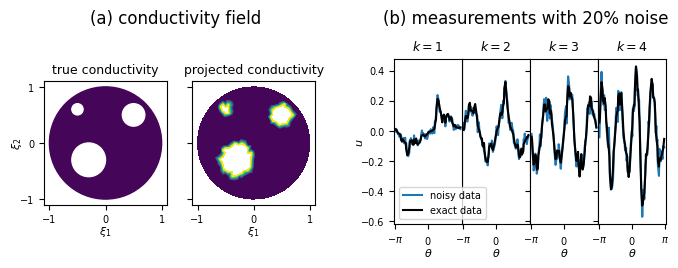

In [10]:
plot_figure6(parameter_space, exact_data, data)
plt.savefig('./plots/data.pdf',format='pdf')

Plot figure 7:

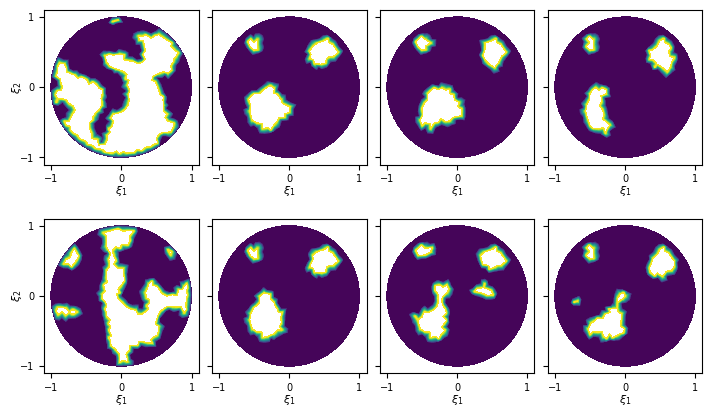

In [11]:
plot_figure7(prior_samples, cuqi_samples1, cuqi_samples2, cuqi_samples3,
             prior_samples_idx_to_plot=[0, 2], 
             posterior_samples_idx_to_plot=[2, -10])
plt.savefig('./plots/samples.pdf',format='pdf')

Plot figure 8, note that in the paper this figure is cropped to show only panel (a) and (b):

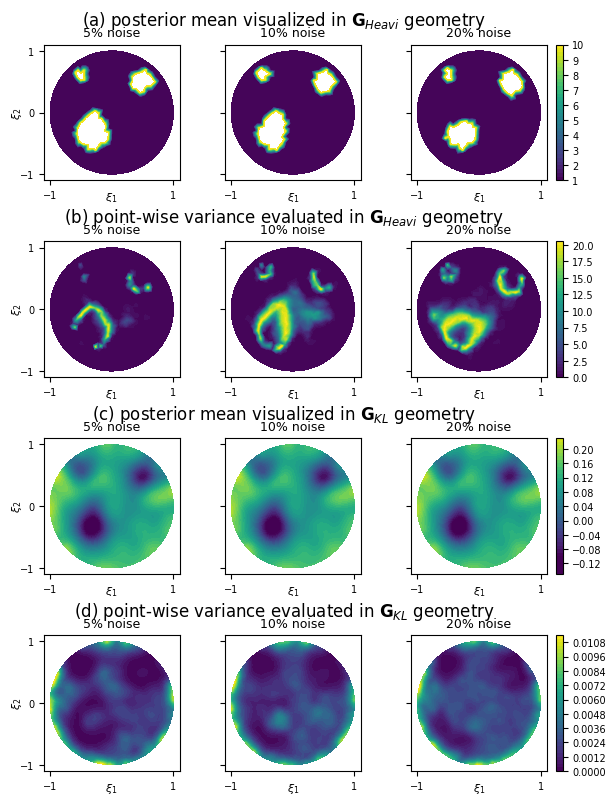

In [12]:
plot_figure8(cuqi_samples1, cuqi_samples2, cuqi_samples3)
plt.savefig('./plots/uq.pdf',format='pdf')

Plot figure 9:

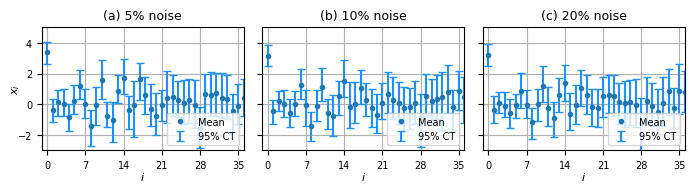

In [13]:
plot_figure9(cuqi_samples1, cuqi_samples2, cuqi_samples3)
plt.savefig('./plots/params.pdf',format='pdf')

In [14]:
!pip freeze

anyio==4.3.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
arviz==0.15.1
asttokens==2.4.1
async-lru==2.0.4
attrs==23.2.0
Babel==2.14.0
backcall==0.2.0
beautifulsoup4==4.12.3
beniget==0.4.1
bleach==6.1.0
certifi==2023.5.7
cffi==1.16.0
charset-normalizer==3.3.2
comm==0.2.0
contourpy==1.1.0
CUQIpy==1.0.0
CUQIpy-FEniCS==0.7.0
cycler==0.11.0
Cython @ file:///tmp/sebo3.8.17-0.29.35/Cython-0.29.35
debugpy==1.8.0
decorator==5.1.1
defusedxml==0.7.1
distlib==0.3.6
docopt==0.6.2
exceptiongroup==1.1.3
executing==2.0.1
fastjsonschema==2.19.1
fenics-dijitso==2019.1.0
fenics-dolfin @ file:///tmp/sebo/fenics/dolfin/python
fenics-ffc==2019.1.0.post0
fenics-fiat==2019.1.0
fenics-ufl==2019.1.0
filelock==3.12.2
fonttools==4.40.0
fqdn==1.5.1
gast==0.5.4
h11==0.14.0
h5netcdf==1.1.0
h5py==3.10.0
httpcore==1.0.4
httpx==0.27.0
idna==3.6
importlib-metadata==6.8.0
importlib-resources==5.12.0
iniconfig==2.0.0
ipykernel==6.26.0
ipython==8.12.3
isoduration==20.11.0
jedi==0.19.1
Jinja2==3.1.3
json5==